Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.86MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]


Epoch 1, Loss: 175.2915
Epoch 2, Loss: 48.0901
Epoch 3, Loss: 32.6774
Epoch 4, Loss: 25.1852
Epoch 5, Loss: 19.7182
Epoch 6, Loss: 15.3198
Epoch 7, Loss: 13.1679
Epoch 8, Loss: 11.1441
Epoch 9, Loss: 7.4884
Epoch 10, Loss: 7.7727
Step 0 | Total Loss: 0.1594 | CE: 0.0033 | L2: 0.0057 | Perceptual: 0.1107 | TV: 0.0397
Step 100 | Total Loss: 0.0579 | CE: 0.0000 | L2: 0.0065 | Perceptual: 0.0290 | TV: 0.0225
Step 200 | Total Loss: 0.0475 | CE: 0.0000 | L2: 0.0070 | Perceptual: 0.0152 | TV: 0.0253
Step 300 | Total Loss: 0.0460 | CE: 0.0000 | L2: 0.0072 | Perceptual: 0.0126 | TV: 0.0262
Step 400 | Total Loss: 0.0456 | CE: 0.0000 | L2: 0.0072 | Perceptual: 0.0122 | TV: 0.0262
Step 500 | Total Loss: 0.0453 | CE: 0.0000 | L2: 0.0072 | Perceptual: 0.0118 | TV: 0.0263
Step 600 | Total Loss: 0.0452 | CE: 0.0000 | L2: 0.0071 | Perceptual: 0.0118 | TV: 0.0263
Step 700 | Total Loss: 0.0452 | CE: 0.0000 | L2: 0.0071 | Perceptual: 0.0117 | TV: 0.0263
Step 800 | Total Loss: 0.0452 | CE: 0.0000 | L2: 0.0

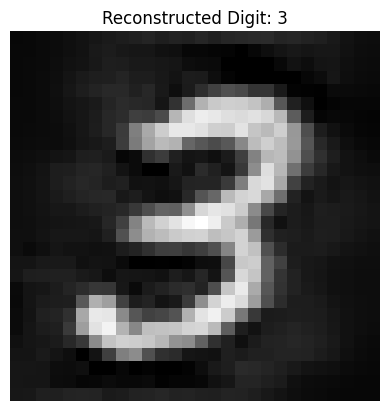


🔍 Prediction Analysis:
Predicted class: 3
Confidence in target class (3): 1.0000

📊 Similarity Metrics:
MSE (pixel-wise): 0.0253
SSIM (structural): 0.6699


In [1]:
# ============================================
# 🔐 WHITE-BOX MODEL INVERSION ATTACK (MNIST)
# ============================================

# This script implements a WHITE-BOX MODEL INVERSION ATTACK.
# The goal is to reconstruct a realistic-looking image of a target digit (e.g., "3")
# by optimizing a randomly initialized input image, using access to the model’s
# gradients and internal features.

# ✅ ATTACK TYPE: Model Inversion Attack
# ✅ ATTACK SETTING: White-box (access to model internals & gradients)
# ✅ METHOD: Gradient Descent Optimization
# ✅ LOSSES USED:
#   - Cross-Entropy Loss (classification confidence for target digit)
#   - Perceptual Loss (feature similarity to a real image)
#   - L2 Regularization (smooth pixel values)
#   - Total Variation Loss (reduce high-frequency noise)
#   - Gaussian Blur (denoise intermediate reconstructions)

# 📚 KEY RELATED PAPERS:
# - Fredrikson et al., 2015 ("Model Inversion Attacks...")
# - Mahendran & Vedaldi, 2015 ("Understanding Deep Representations...")


# 🛠️ TOOLCHAIN: PyTorch, torchvision, skimage, matplotlib
# 🧪 DATASET: MNIST
# ============================================




import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

    def get_features(self, x):
        return self.conv(x)

# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train the model
model = CNN_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

torch.save(model.state_dict(), 'mnist_cnn.pth')

# Load the trained model
model.load_state_dict(torch.load('mnist_cnn.pth'))
model.eval()

# Target label to invert (e.g., digit 3)
target_label = 3
target_class = torch.tensor([target_label], dtype=torch.long).to(device)

# Initialize with mean image of the target digit + noise
mean_img = torch.zeros((1, 1, 28, 28), device=device)
count = 0
for img, label in train_dataset:
    if label == target_label:
        mean_img += img.to(device)
        count += 1
mean_img /= count
reconstructed_img = (mean_img + torch.randn_like(mean_img) * 0.1).requires_grad_(True)

# Optimizer and scheduler for image
optimizer = optim.AdamW([reconstructed_img], lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.7)
loss_fn = nn.CrossEntropyLoss()

# Total Variation Loss
def tv_loss(img):
    h_var = torch.sum((img[:, :, 1:, :] - img[:, :, :-1, :])**2)
    w_var = torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1])**2)
    return h_var + w_var

# Gaussian smoothing
def gaussian_blur(img):
    kernel = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32, device=device) / 16
    kernel = kernel.view(1, 1, 3, 3)
    return F.conv2d(img, kernel, padding=1)

# Get real image features of the target digit
target_image = None
for img, label in train_dataset:
    if label == target_label:
        target_image = img
        break

if target_image is None:
    raise ValueError(f"Target label {target_label} not found in dataset")

target_image = target_image.unsqueeze(0).to(device)
target_features = model.get_features(target_image)

# Inversion loop
for step in range(2500):
    optimizer.zero_grad()
    output = model(reconstructed_img)
    loss = loss_fn(output, target_class)
    l2_loss = torch.sum(reconstructed_img ** 2) * 0.0001
    perceptual_loss = F.mse_loss(model.get_features(reconstructed_img), target_features) * 0.5
    tv = tv_loss(reconstructed_img) * 0.001
    total_loss = loss + l2_loss + perceptual_loss + tv
    total_loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_([reconstructed_img], 5.0)
    optimizer.step()
    scheduler.step()
    with torch.no_grad():
        reconstructed_img.clamp_(0, 1)
        if step % 50 == 0:
            reconstructed_img.copy_(gaussian_blur(reconstructed_img).clamp_(0, 1))
    if step % 100 == 0:
        print(f"Step {step} | Total Loss: {total_loss.item():.4f} | CE: {loss.item():.4f} | "
              f"L2: {l2_loss.item():.4f} | Perceptual: {perceptual_loss.item():.4f} | TV: {tv.item():.4f}")
        plt.imshow(reconstructed_img.squeeze().detach().cpu(), cmap='gray')
        plt.title(f"Step {step}")
        plt.axis('off')
        plt.savefig(f"mnist_reconstructed_step_{step}.png")
        plt.close()

# Final image
plt.imshow(reconstructed_img.squeeze().detach().cpu(), cmap='gray')
plt.title(f"Reconstructed Digit: {target_label}")
plt.axis('off')
plt.savefig('mnist_reconstructed_final.png')
plt.show()

# Evaluation
with torch.no_grad():
    probs = F.softmax(model(reconstructed_img), dim=1)
    confidence = probs[0, target_label].item()
    predicted_class = torch.argmax(probs).item()

print(f"\n🔍 Prediction Analysis:")
print(f"Predicted class: {predicted_class}")
print(f"Confidence in target class ({target_label}): {confidence:.4f}")

original_np = target_image.squeeze().cpu().numpy()
reconstructed_np = reconstructed_img.squeeze().detach().cpu().numpy()

mse_val = np.mean((original_np - reconstructed_np) ** 2)
ssim_val = ssim(original_np, reconstructed_np, data_range=1.0)

print(f"\n📊 Similarity Metrics:")
print(f"MSE (pixel-wise): {mse_val:.4f}")
print(f"SSIM (structural): {ssim_val:.4f}")


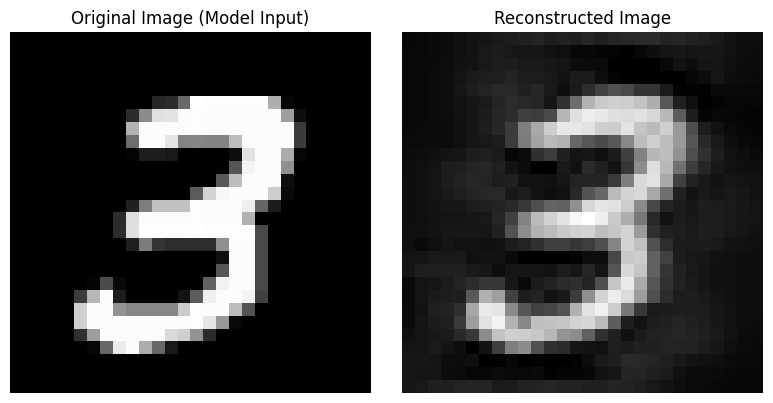

In [2]:
# Visualize original vs reconstructed
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(target_image.squeeze().cpu().numpy(), cmap='gray')
axes[0].set_title("Original Image (Model Input)")
axes[0].axis('off')

axes[1].imshow(reconstructed_img.squeeze().detach().cpu().numpy(), cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.tight_layout()
plt.savefig('mnist_comparison.png')
plt.show()